In [47]:
# !pip install bareunpy
# !pip install kiwipiepy

In [25]:
import sys
import google.protobuf.text_format as tf
from bareunpy import Tokenizer, Tagger

API_KEY = my_key # <- 본인의 API KEY로 교체(Replace this with your own API KEY)
my_tokenizer = Tokenizer(API_KEY, 'localhost')

In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Hannanum,Kkma,Komoran,Mecab,Okt

In [27]:
from tqdm import tqdm, trange

tqdm.pandas()

In [28]:
train_path = './data/ratings_train.txt'
test_path = './data/ratings_test.txt'

train = pd.read_table(train_path)
test = pd.read_table(test_path)

In [6]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (150000, 3) 
test shape => (50000, 3)


### 최종 전처리 함수
- 한글, 숫자, 초성, ♥♡乃ㄳㅄ의 문자를 남겼다
- 초성 ㅜㅜ, ㅋㅋ이 감정의 의미를 담을 수 있다고 파악했기 때문이다
- 다중 공백을 제거하는 코드를 추가하였다
- ㅋ와 ㅋㅋ은 다르게 인지하였다
    - ㅜㅜㅜ, ㅋㅋㅋㅋㅋㅋ 등의 다중 초성은 2개의 초성으로 모두 합쳐주었다
- 빈 하트와 채워진 하트는 채워진 하트로 통일하고 하트의 갯수는 모두 하나로 바꿔주었다
- 반복되는 문자열은 하나만 남기고 지워줬다

In [29]:
import re

In [9]:
def preprocessing(train, col='document'):
    train[col] = train[col].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9♥♡乃ㄳㅄ ]","") # 정규 표현식 수행
    train[col] = train[col].str.replace('^ +', "") # 공백은 empty 값으로 변경
    train[col].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
    train.dropna(how='any', inplace=True)
    
    train[col] = train[col].apply(lambda x: re.sub(r'(ㅋ|ㅎ|ㅜ|ㅠ){2,}', lambda m: m.group(1) * 2, x)) # 반복되는 2자리 문자 처리

    train[col] = train[col].str.replace(r'♡','♥')
    train[col] = train[col].apply(lambda x: re.sub(r'♥+', '♥', x))
    train[col] = train[col].apply(lambda x: re.sub(r'\b(\S+)( \1)+', r'\1', x))
    train[col] = train[col].apply(lambda x: ' '.join(x.split()))
    return train

In [10]:
train = preprocessing(train, col='document')
test = preprocessing(test, col='document')

/var/folders/1b/dx8_94fs0q740wx3lfknk6y40000gn/T/ipykernel_99410/2614627157.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train[col] = train[col].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9♥♡乃ㄳㅄ ]","") # 정규 표현식 수행
/var/folders/1b/dx8_94fs0q740wx3lfknk6y40000gn/T/ipykernel_99410/2614627157.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train[col] = train[col].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [11]:
# 훈련 데이터와 테스트 데이터 분리
train_texts, train_labels = train['document'].tolist(), train['label'].tolist()
test_texts, test_labels = test['document'].tolist(), test['label'].tolist()

In [12]:
import os
os.environ["JAVA_HOME"] = '/Library/Java/JavaVirtualMachines/jdk-1.8.jdk/Contents/Home'

In [13]:
texts = train_texts[:1000]

In [13]:
import time
from konlpy.tag import Okt, Kkma, Hannanum, Komoran, Mecab
from kiwipiepy import Kiwi

# 토크나이저 초기화
okt = Okt()
kkma = Kkma()
komoran = Komoran()
mecab = Mecab()
kiwi = Kiwi()
hannanum = Hannanum()

# 토크나이저 함수 정의
def tokenize_okt(texts):
    return [okt.pos(text) for text in tqdm(texts)]

def tokenize_hannanum(texts):
    return [hannanum.pos(text) for text in tqdm(texts)]

def tokenize_kkma(texts):
    return [kkma.pos(text) for text in tqdm(texts)]

def tokenize_komoran(texts):
    return [komoran.pos(text) for text in tqdm(texts)]

def tokenize_mecab(texts):
    return [mecab.pos(text) for text in tqdm(texts)]

def tokenize_kiwi(texts):
    return [kiwi.tokenize(text) for text in tqdm(texts)]

def tokenize_bareun(texts):
    bareun = Tagger(API_KEY, 'localhost')
    return [bareun.tags([text]).pos() for text in tqdm(texts)]

def tokenize_okt_norm(texts):
    return [okt.pos(text, norm=True) for text in tqdm(texts)]

def tokenize_okt_norm_stem(texts):
    return [okt.pos(text, stem=True, norm=True) for text in tqdm(texts)]

def tokenize_okt_stem(texts):
    return [okt.pos(text, stem=True) for text in tqdm(texts)]

# 토크나이저 실행 시간 측정
def measure_time(tokenizer, texts, iterations=5):
    total_time = 0
    for _ in range(iterations):
        start_time = time.time()
        tokens = tokenizer(texts)
        end_time = time.time()
        total_time += end_time - start_time
    average_time = total_time / iterations
    return tokens, average_time

# 고정된 조건에서 성능 측정
iterations = 5

In [96]:
# 토큰화 및 실행 시간 측정
train_tokens_okt, time_okt = measure_time(tokenize_okt, texts)
print(f"Okt 실행 시간: {time_okt:.2f} 초")

train_tokens_kkma, time_kkma = measure_time(tokenize_kkma, texts)
print(f"Kkma 실행 시간: {time_kkma:.2f} 초")

train_tokens_komoran, time_komoran = measure_time(tokenize_komoran, texts)
print(f"Komoran 실행 시간: {time_komoran:.2f} 초")

train_tokens_mecab, time_mecab = measure_time(tokenize_mecab, texts)
print(f"Mecab 실행 시간: {time_mecab:.2f} 초")

train_tokens_hannanum, time_hannanum = measure_time(tokenize_hannanum, texts)
print(f"Hannanum 실행 시간: {time_hannanum:.2f} 초")

train_tokens_kiwi, time_kiwi = measure_time(tokenize_kiwi, texts)
print(f"Kiwi 실행 시간: {time_kiwi:.2f} 초")

train_tokens_bareun, time_bareun = measure_time(tokenize_bareun, texts)
print(f"bareun 실행 시간: {time_bareun:.2f} 초")

train_tokens_okt_norm, time_okt_norm = measure_time(tokenize_okt_norm, texts)
print(f"Okt norm 실행 시간: {time_okt_norm:.2f} 초")

train_tokens_okt_stem, time_okt_stem = measure_time(tokenize_okt_stem, texts)
print(f"Okt stem 실행 시간: {time_okt_stem:.2f} 초")

train_tokens_okt_norm_stem, time_okt_norm_stem = measure_time(tokenize_okt_norm_stem, texts)
print(f"Okt norm_stem 실행 시간: {time_okt_norm_stem:.2f} 초")

Okt 실행 시간: 1.44 초
Kkma 실행 시간: 12.80 초
Komoran 실행 시간: 0.28 초
Mecab 실행 시간: 0.02 초
Hannanum 실행 시간: 2.21 초
Kiwi 실행 시간: 0.66 초
bareun 실행 시간: 12.16 초
Okt norm 실행 시간: 4.04 초
Okt stem 실행 시간: 2.27 초
Okt norm_stem 실행 시간: 4.04 초


In [16]:
# train_tokens_okt[0]
# train_tokens_kkma[0]
# train_tokens_komoran[0]
# train_tokens_hannanum[0]
# train_tokens_kiwi[0]
# train_tokens_mecab[0]
# train_tokens_bareun[0]
# train_tokens_okt_norm[0]
# train_tokens_okt_stem[0]
# train_tokens_okt_norm_stem[0]

In [122]:
# !pip install soynlp

In [17]:
from soynlp.tokenizer import RegexTokenizer, LTokenizer, MaxScoreTokenizer
from soynlp.word import WordExtractor

word_extractor = WordExtractor(min_frequency=100,
    min_cohesion_forward=0.05, 
    min_right_branching_entropy=0.0
)
word_extractor.train(train['document'].tolist() + test['document'].tolist()) # list of str or like
words = word_extractor.extract()

training was done. used memory 1.038 Gbse memory 0.742 Gb
all cohesion probabilities was computed. # words = 5647
all branching entropies was computed # words = 105708
all accessor variety was computed # words = 105708


In [18]:
len(words)

3836

In [19]:
import math

def word_score(score):
    return (score.cohesion_forward * math.exp(score.right_branching_entropy))

print('단어   (빈도수, cohesion, branching entropy)\n')
for word, score in sorted(words.items(), key=lambda x:word_score(x[1]), reverse=True)[:30]:
    print('%s     (%d, %.3f, %.3f)' % (
            word, 
            score.leftside_frequency, 
            score.cohesion_forward,
            score.right_branching_entropy
            )
         )

단어   (빈도수, cohesion, branching entropy)

ㅋㅋ     (6727, 0.973, 5.095)
영화     (57286, 0.941, 4.929)
ㅠㅠ     (2061, 0.958, 4.890)
ㅎㅎ     (1614, 0.925, 4.835)
ㅡㅡ     (1616, 0.958, 4.682)
합니다     (363, 0.750, 4.860)
ㅜㅜ     (705, 0.948, 4.602)
드라마     (5249, 0.858, 4.665)
너무     (14503, 0.970, 4.480)
진짜     (9613, 0.676, 4.838)
차라리     (865, 0.656, 4.772)
입니다     (301, 0.540, 4.919)
된다     (477, 0.646, 4.714)
든다     (248, 0.895, 4.339)
정말     (11882, 0.677, 4.582)
뭔가     (1288, 0.674, 4.584)
역시     (2391, 0.523, 4.831)
솔직히     (1318, 0.898, 4.285)
준다     (447, 0.559, 4.716)
봤는데     (3338, 0.573, 4.671)
까지     (267, 0.402, 5.009)
근데     (990, 0.724, 4.359)
완전     (3135, 0.691, 4.357)
때문에     (918, 0.660, 4.401)
항상     (394, 0.849, 4.138)
계속     (1170, 0.731, 4.202)
ㅉㅉ     (472, 0.983, 3.869)
마지막에     (789, 0.443, 4.662)
함께     (711, 0.764, 4.066)
그리고     (2135, 0.288, 5.037)


In [45]:
scores = {}
lscores = {}
for word, score in sorted(words.items(), key=lambda x:word_score(x[1]), reverse=True):
    lscores[word] = score.cohesion_forward
    scores[word] = word_score(score)

In [21]:
scores

{'ㅋㅋ': 158.81836633039003,
 '영화': 130.0173922454327,
 'ㅠㅠ': 127.44209945198614,
 'ㅎㅎ': 116.38622962127909,
 'ㅡㅡ': 103.5018067716247,
 '합니다': 96.7938631591607,
 'ㅜㅜ': 94.44436346879404,
 '드라마': 91.15529783966187,
 '너무': 85.52745994842417,
 '진짜': 85.23054325353004,
 '차라리': 77.46322260892377,
 '입니다': 73.92772504374274,
 '된다': 72.08486954723155,
 '든다': 68.57750388757142,
 '정말': 66.2078033089349,
 '뭔가': 66.00355950646548,
 '역시': 65.52763542176626,
 '솔직히': 65.21595731181061,
 '준다': 62.39722377088773,
 '봤는데': 61.1772329399878,
 '까지': 60.23217772617534,
 '근데': 56.58006394791445,
 '완전': 53.902518020296654,
 '때문에': 53.79905772440471,
 '항상': 53.236084658025064,
 '계속': 48.81391963325982,
 'ㅉㅉ': 47.10496028620962,
 '마지막에': 46.84775704384907,
 '함께': 44.529958610964485,
 '그리고': 44.43281772753415,
 '갈수록': 43.66909354352431,
 '개인적으로': 43.20377179037424,
 '얼마나': 40.875593880759254,
 '갑자기': 40.658330748075535,
 'ㄷㄷ': 40.23880915565518,
 '됩니다': 39.823865320584595,
 '봤습니다': 36.927228691029676,
 '그냥': 36.91

In [22]:
cohesion_scores = word_extractor.all_cohesion_scores()
cohesion_scores['별로'] # (cohesion_forward, cohesion_backward)

all cohesion probabilities was computed. # words = 5647


(0.565947242206235, 0.00426182930827232)

In [23]:
def word_score(score):
    return (score.cohesion_forward * math.exp(score.right_branching_entropy))

In [24]:
branching_entropy = word_extractor.all_branching_entropy()
branching_entropy['별로'] # (left_branching_entropy, right_branching_entropy)

all branching entropies was computed # words = 105708


(3.6782606986656257, 3.6982209638368735)

In [25]:
accessor_variety = word_extractor.all_accessor_variety()
accessor_variety['별로'] # (left_accessor_variety, right_accessor_variety)

all accessor variety was computed # words = 105708


(121, 149)

In [42]:
ms_soy = MaxScoreTokenizer(scores=scores)
ms_soy.tokenize('ㅋㅋ영화노잼')

['ㅋㅋ', '영화', '노잼']

In [31]:
def tokenize_soy(texts):
    return [tokenizer.tokenize(text) for text in texts]

In [39]:
train_tokens_soy, time_soy = measure_time(tokenize_soy, texts)
print(f"Soynlp 실행 시간: {time_soy:.2f} 초")

Soynlp 실행 시간: 0.05 초


In [33]:
train

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


In [46]:
from soynlp.tokenizer import LTokenizer

ltokenizer = LTokenizer(scores =lscores)

In [47]:
def tokenize_soyl(texts):
    return [ltokenizer.tokenize(text) for text in texts]

In [48]:
train_tokens_soyl, time_soyl = measure_time(tokenize_soyl, texts)
print(f"Soynlp 실행 시간: {time_soyl:.2f} 초")

Soynlp 실행 시간: 0.01 초


In [49]:
train.head()

,id,document,label,ltokenizer,max_score
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 더빙, 진짜, 짜증, 나네요, 목소리]","[아, 더빙, 진짜, 짜증, 나네요, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠포스터보고, 초딩, 영화줄오버연기조차, 가볍지, 않구나]","[흠, 포스터, 보고, 초딩, 영화, 줄오버, 연기, 조차, 가볍지, 않구나]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너무, 재밓었다그래서보는것을추천한다]","[너무, 재밓었다, 그래서, 보는, 것을, 추천, 한다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 구먼, 솔직히, 재미, 는, 없다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직히, 재미, 는, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이몬페그의, 익살스런, 연기, 가, 돋보, 였던, 영화, 스파이더맨에서, 늙어보...","[사이몬페그의, 익살스런, 연기, 가, 돋보, 였던, 영화, 스, 파이, 더맨, 에..."


In [50]:
train['ltokenizer'] = train['document'].apply(lambda x: ltokenizer.tokenize(x))
test['ltokenizer'] = test['document'].apply(lambda x: ltokenizer.tokenize(x))
train['max_score'] = train['document'].apply(lambda x: ms_soy.tokenize(x))
test['max_score'] = test['document'].apply(lambda x: ms_soy.tokenize(x))

In [51]:
train.head()

,id,document,label,ltokenizer,max_score
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 더빙, 진짜, 짜증, 나네요, 목소리]","[아, 더빙, 진짜, 짜증, 나네요, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠포스터보고, 초딩, 영화줄오버연기조차, 가볍지, 않구나]","[흠, 포스터, 보고, 초딩, 영화, 줄오버, 연기, 조차, 가볍지, 않구나]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너무, 재밓었다그래서보는것을추천한다]","[너무, 재밓었다, 그래서, 보는, 것을, 추천, 한다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 구먼, 솔직, 히, 재미, 는, 없다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직히, 재미, 는, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이몬페그의, 익살스런, 연기, 가, 돋보, 였던, 영화, 스파이더맨에서, 늙어보...","[사이몬페그의, 익살스런, 연기, 가, 돋보, 였던, 영화, 스, 파이, 더맨, 에..."


In [54]:
kiwi_tok = tokenize_kiwi(train['document'].tolist())
bareun_tok = tokenize_bareun(train['document'].tolist())

100%|██████████| 148909/148909 [33:42<00:00, 73.61it/s] 


In [55]:
train['kiwi'] = kiwi_tok
train['bareun'] = bareun_tok

In [57]:
kiwi_tok_test = tokenize_kiwi(test['document'].tolist())
bareun_tok_test = tokenize_bareun(test['document'].tolist())

100%|██████████| 49638/49638 [11:31<00:00, 71.81it/s]


In [58]:
test['kiwi'] = kiwi_tok_test
test['bareun'] = bareun_tok_test

In [59]:
train.to_csv('train_tokens.csv', index=False)
test.to_csv('test_tokens.csv', index=False)

In [ ]:
train.head()

### test

In [1]:
import pandas as pd
from ast import literal_eval
from tqdm import tqdm, trange

tqdm.pandas()

In [2]:
import re

In [3]:
train = pd.read_csv('data/train_tokens.csv')
test = pd.read_csv('data/test_tokens.csv')

In [4]:
train_konlpy = pd.read_csv('data/train_konlpy.csv')
test_konlpy = pd.read_csv('data/test_konlpy.csv')

In [5]:
train_konlpy.columns

Index(['id', 'document', 'label', 'Hannanum', 'Komoran', 'Mecab', 'Okt',
       'Okt_stem'],
      dtype='object')

In [6]:
test_konlpy.head()

,id,document,label,Hannanum,Komoran,Mecab,Okt,Okt_stem
0,6270596,굳 ㅋ,1,"['굳', 'ㅋ']","['굳', 'ㅋ']","['굳', 'ㅋ']","['굳', 'ㅋ']","['굳다', 'ㅋ']"
1,8544678,뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,"['뭐', '이', '야', '이', '평점들', '은', '나쁘진', '않', '...","['뭐', '야', '이', '평점', '들', '은', '나쁘', '지', 'ㄴ'...","['뭐', '야', '이', '평점', '들', '은', '나쁘', '진', '않'...","['뭐', '야', '이', '평점', '들', '은', '나쁘진', '않지만', ...","['뭐', '야', '이', '평점', '들', '은', '나쁘다', '않다', '..."
2,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,"['지루', '하', '어', '지', '는', '않', '은', '데', '완전'...","['지루', '하', '지', '는', '않', '은데', '완전', '막장', '...","['지루', '하', '지', '는', '않', '은데', '완전', '막장', '...","['지루하지는', '않은데', '완전', '막장', '임', '돈', '주고', '...","['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기..."
3,6723715,3만 아니었어도 별 다섯 개 줬을텐데 왜 3로 나와서 제 심기를 불편하게 하죠,0,"['3', '만', '아니', '었어도', '별', '다섯', '개', '주', '...","['3', '만', '아니', '었', '어도', '별', '다섯', '개', '주...","['3', '만', '아니', '었', '어도', '별', '다섯', '개', '줬...","['3만', '아니었어도', '별', '다섯', '개', '줬을텐데', '왜', '...","['3만', '아니다', '별', '다섯', '개', '주다', '왜', '3', ..."
4,7898805,음악이 주가 된 최고의 음악영화,1,"['음악', '이', '주', '가', '되', 'ㄴ', '최고', '의', '음악...","['음악', '이', '주가', '되', 'ㄴ', '최고', '의', '음악', '...","['음악', '이', '주', '가', '된', '최고', '의', '음악', '영화']","['음악', '이', '주가', '된', '최고', '의', '음악', '영화']","['음악', '이', '주가', '되다', '최고', '의', '음악', '영화']"


In [7]:
for col in tqdm(['Hannanum', 'Komoran', 'Mecab', 'Okt', 'Okt_stem']):
    train[col] = train_konlpy[col].apply(lambda x: literal_eval(str(x)))
    test[col] = test_konlpy[col].apply(lambda x: literal_eval(str(x)))

100%|██████████| 5/5 [00:17<00:00,  3.49s/it]


In [8]:
for col in tqdm(['ltokenizer', 'max_score','bareun']):
    train[col] = train[col].apply(lambda x: literal_eval(str(x)))
    test[col] = test[col].apply(lambda x: literal_eval(str(x)))

100%|██████████| 3/3 [00:17<00:00,  5.76s/it]


In [9]:
train['bareun'] = train['bareun'].apply(lambda x: [l[0] for l in x])
test['bareun'] = test['bareun'].apply(lambda x: [l[0] for l in x])
train['kiwi'] = train['kiwi'].apply(lambda x: re.findall(r"form='(.*?)'", x))
test['kiwi'] = test['kiwi'].apply(lambda x: re.findall(r"form='(.*?)'", x))

In [10]:
train.head()

,id,document,label,ltokenizer,max_score,kiwi,bareun,Hannanum,Komoran,Mecab,Okt,Okt_stem
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 더빙, 진짜, 짜증, 나네요, 목소리]","[아, 더빙, 진짜, 짜증, 나네요, 목소리]","[아, 더빙, 진짜, 짜증, 나, 네요, 목소리]","[아, 더빙, 진짜, 짜증, 나, 네, 요, 목소리]","[아, 더빙, 진짜, 짜증나, 네, 요, 목소리]","[아, 더빙, 진짜, 짜증, 나, 네요, 목소리]","[아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]","[아, 더빙, 진짜, 짜증나네요, 목소리]","[아, 더빙, 진짜, 짜증나다, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠포스터보고, 초딩, 영화줄오버연기조차, 가볍지, 않구나]","[흠, 포스터, 보고, 초딩, 영화, 줄오버, 연기, 조차, 가볍지, 않구나]","[흠, 포스터, 보, 고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않...","[흠포스터, 보고, 초딩, 영화, 줄오버, 연기, 조차, 가볍, 지, 않, 구나]","[흠포스터보, 이, 고, 초딩영화줄오버연기조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍지, 않구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍다, 않다]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너무, 재밓었다그래서보는것을추천한다]","[너무, 재밓었다, 그래서, 보는, 것을, 추천, 한다]","[너무재밓, 었, 다, 그래서, 보, 는, 것, 을, 추천, 하, ᆫ다]","[너무, 재밓, 었, 다, 그렇, 어서, 보, 는, 것, 을, 추천하, ㄴ다]",[너무재밓었다그래서보는것을추천한다],[너무재밓었다그래서보는것을추천한다],"[너무, 재, 밓었다그래서보는것을추천한다]","[너, 무재, 밓었, 다그, 래서, 보는것을, 추천, 한, 다]","[너, 무재, 밓었, 다그, 래서, 보다, 추천, 한, 다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 구먼, 솔직, 히, 재미, 는, 없다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직히, 재미, 는, 없다, 평점, 조정]","[교도소, 이야기, 이, 구먼, 솔직히, 재미, 는, 없, 다, 평점, 조정]","[교도소, 이야기, 이, 구먼, 솔직히, 재미, 는, 없, 다, 평점, 조정]","[교도소, 이야기구먼, 솔직히, 재미, 는, 없다평점, 조정]","[교도소, 이야기, 이, 구먼, 솔직히, 재미, 는, 없, 다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직히, 재미, 는, 없, 다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직히, 재미, 는, 없다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직하다, 재미, 는, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이몬페그의, 익살스런, 연기, 가, 돋보, 였던, 영화, 스파이더맨에서, 늙어보...","[사이몬페그의, 익살스런, 연기, 가, 돋보, 였던, 영화, 스, 파이, 더맨, 에...","[사이몬페그, 의, 익살, 스럽, ᆫ, 연기, 가, 돋보이, 었, 던, 영화, 스파...","[사이몬페그, 의, 익살스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, 스파이더...","[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보이, 었던, 영화스파이더맨, 에서...","[사이몬페그의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, 스파이더...","[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보였, 던, 영화, 스파이더맨, 에...","[사이, 몬페, 그, 의, 익살스런, 연기, 가, 돋보였던, 영화, 스파이더맨, 에...","[사이, 몬페, 그, 의, 익살스럽다, 연기, 가, 돋보이다, 영화, 스파이더맨, ..."


In [11]:
test.head()

,id,document,label,ltokenizer,max_score,kiwi,bareun,Hannanum,Komoran,Mecab,Okt,Okt_stem
0,6270596,굳 ㅋ,1,"[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳다, ㅋ]"
1,8544678,뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,"[뭐야, 이, 평점, 들은, 나쁘진, 않지만, 10점, 짜리는, 더더욱, 아니, 잖아]","[뭐야, 이, 평점, 들은, 나쁘진, 않지만, 1, 0점, 짜리는, 더, 더욱, 아...","[뭐, 이, 야, 이, 평점, 들, 은, 나쁘, 지, ᆫ, 않, 지만, 10, 점,...","[뭐, 이, 야, 이, 평점, 들, 은, 나쁘, 지, ㄴ, 않, 지만, 10, 점,...","[뭐, 이, 야, 이, 평점들, 은, 나쁘진, 않, 지, 말, ㄴ, 10점, 짜, ...","[뭐, 야, 이, 평점, 들, 은, 나쁘, 지, ㄴ, 않, 지만, 10, 점, 짜리...","[뭐, 야, 이, 평점, 들, 은, 나쁘, 진, 않, 지만, 10, 점, 짜리, 는...","[뭐, 야, 이, 평점, 들, 은, 나쁘진, 않지만, 10, 점, 짜, 리, 는, ...","[뭐, 야, 이, 평점, 들, 은, 나쁘다, 않다, 10, 점, 짜다, 리, 는, ..."
2,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,"[지루하, 지는, 않은, 데, 완전, 막장, 임, 돈주고, 보기에는]","[지루, 하지, 는, 않은, 데, 완전, 막장, 임, 돈주고, 보기에는]","[지루하, 지, 는, 않, 은데, 완전, 막장, 이, ᆷ, 돈, 주, 고, 보, 기...","[지루하, 지, 는, 않, 은데, 완전, 막장임, 돈, 주, 고, 보, 기, 에, 는]","[지루, 하, 어, 지, 는, 않, 은, 데, 완전, 막장, 이, ㅁ, 돈주, 이,...","[지루, 하, 지, 는, 않, 은데, 완전, 막장, 이, ㅁ, 돈, 주, 고, 보,...","[지루, 하, 지, 는, 않, 은데, 완전, 막장, 임, 돈, 주, 고, 보, 기,...","[지루하지는, 않은데, 완전, 막장, 임, 돈, 주고, 보기, 에는]","[지루하다, 않다, 완전, 막장, 임, 돈, 주다, 보기, 에는]"
3,6723715,3만 아니었어도 별 다섯 개 줬을텐데 왜 3로 나와서 제 심기를 불편하게 하죠,0,"[3만, 아니, 었어도, 별, 다섯, 개, 줬을텐데, 왜, 3로, 나와서, 제, 심...","[3만, 아니, 었어도, 별, 다섯, 개, 줬을텐데, 왜, 3로, 나와서, 제, 심...","[3, 만, 아니, 었, 어도, 별, 다섯, 개, 주, 었, 을, 터, 이, ᆫ데,...","[3, 만, 아니, 었, 어도, 별, 다섯, 개, 주, 었, 을, 터, 이, ㄴ데,...","[3, 만, 아니, 었어도, 별, 다섯, 개, 주, 었을텐데, 왜, 3, 로, 나오...","[3, 만, 아니, 었, 어도, 별, 다섯, 개, 주, 었, 을, 텐, 데, 왜, ...","[3, 만, 아니, 었, 어도, 별, 다섯, 개, 줬, 을, 텐데, 왜, 3, 로,...","[3만, 아니었어도, 별, 다섯, 개, 줬을텐데, 왜, 3, 로, 나와서, 제, 심...","[3만, 아니다, 별, 다섯, 개, 주다, 왜, 3, 로, 나오다, 제, 심기, 를..."
4,7898805,음악이 주가 된 최고의 음악영화,1,"[음악, 이, 주가, 된, 최고, 의, 음악, 영화]","[음악, 이, 주가, 된, 최고의, 음악, 영화]","[음악, 이, 주, 가, 되, ᆫ, 최고, 의, 음악, 영화]","[음악, 이, 주, 가, 되, ㄴ, 최고, 의, 음악, 영화]","[음악, 이, 주, 가, 되, ㄴ, 최고, 의, 음악영화]","[음악, 이, 주가, 되, ㄴ, 최고, 의, 음악, 영화]","[음악, 이, 주, 가, 된, 최고, 의, 음악, 영화]","[음악, 이, 주가, 된, 최고, 의, 음악, 영화]","[음악, 이, 주가, 되다, 최고, 의, 음악, 영화]"


In [22]:
# hannanum = Hannanum()
# kkma = Kkma(max_heap_size=2048)
# komoran = Komoran()
# mecab = Mecab()
# okt = Okt()

In [12]:
import os
os.environ["JAVA_HOME"] = '/Library/Java/JavaVirtualMachines/jdk-1.8.jdk/Contents/Home'

In [13]:
import time
from konlpy.tag import Okt, Kkma, Hannanum, Komoran, Mecab
from kiwipiepy import Kiwi

# 토크나이저 초기화
okt = Okt()
kkma = Kkma(max_heap_size=2048)
komoran = Komoran()
mecab = Mecab()
kiwi = Kiwi()
hannanum = Hannanum()

# 토크나이저 함수 정의
def tokenize_okt(texts):
    return [okt.pos(text) for text in tqdm(texts)]

def tokenize_hannanum(texts):
    return [hannanum.pos(text) for text in tqdm(texts)]

def tokenize_kkma(texts):
    return [kkma.pos(text) for text in tqdm(texts)]

def tokenize_komoran(texts):
    return [komoran.pos(text) for text in tqdm(texts)]

def tokenize_mecab(texts):
    return [mecab.pos(text) for text in tqdm(texts)]

def tokenize_kiwi(texts):
    return [kiwi.tokenize(text) for text in tqdm(texts)]

def tokenize_bareun(texts):
    bareun = Tagger(API_KEY, 'localhost')
    return [bareun.tags([text]).pos() for text in tqdm(texts)]

def tokenize_okt_norm(texts):
    return [okt.pos(text, norm=True) for text in tqdm(texts)]

def tokenize_okt_norm_stem(texts):
    return [okt.pos(text, stem=True, norm=True) for text in tqdm(texts)]

def tokenize_okt_stem(texts):
    return [okt.pos(text, stem=True) for text in tqdm(texts)]

In [15]:
from bareunpy import Tokenizer, Tagger

API_KEY = "koba-GRKAAOA-7DDU2WA-TMZS6VY-AIXYICQ"

In [16]:
bareun = Tagger(API_KEY, 'localhost')

In [17]:
tokenizer_list = [hannanum, kkma, komoran, mecab, okt, bareun, kiwi]

# kor_text = '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네'
kor_text = '노래도 너무즐겁고 내용도 아기자기 귀여워요동화같은ㅠ근데 아이들 너무귀엽다♥'

for tokenizer in tokenizer_list:
    if tokenizer == bareun:
        print('[{}] \n{}'.format(tokenizer.__class__.__name__, tokenizer.tags([kor_text]).pos()))
    elif tokenizer == kiwi:
        print('[{}] \n{}'.format(tokenizer.__class__.__name__, tokenizer.tokenize(kor_text)))
    else:
        print('[{}] \n{}'.format(tokenizer.__class__.__name__, tokenizer.pos(kor_text)))

[Hannanum] 
[('노래', 'N'), ('도', 'J'), ('너무즐겁고', 'N'), ('내용', 'N'), ('도', 'J'), ('아기자기', 'N'), ('귀여워요동화같은ㅠ근데', 'N'), ('아이들', 'N'), ('너무귀엽다♥', 'N')]
[Kkma] 
[('노래', 'NNG'), ('도', 'JX'), ('너무', 'MAG'), ('즐겁', 'VA'), ('고', 'ECE'), ('내용', 'NNG'), ('도', 'JX'), ('아기자기', 'MAG'), ('귀엽', 'VA'), ('어', 'ECS'), ('요동', 'NNG'), ('화', 'XSN'), ('같', 'VA'), ('은', 'ETD'), ('ㅠ', 'UN'), ('그', 'VA'), ('ㄴ데', 'ECE'), ('아이', 'NNG'), ('들', 'XSN'), ('너무', 'MAG'), ('귀엽', 'VA'), ('다', 'ECS'), ('♥', 'SW')]
[Komoran] 
[('노래', 'NNG'), ('도', 'JX'), ('너무', 'MAG'), ('즐겁', 'VA'), ('고', 'EC'), ('내용', 'NNG'), ('도', 'JX'), ('아기자기', 'MAG'), ('귀여워요동화같으뉴근데', 'NA'), ('아이들', 'NNP'), ('너무', 'MAG'), ('귀엽', 'VA'), ('다', 'EC'), ('♥', 'SW')]
[Mecab] 
[('노래', 'NNG'), ('도', 'JX'), ('너무', 'MAG'), ('즐겁', 'VA'), ('고', 'EC'), ('내용', 'NNG'), ('도', 'JX'), ('아기', 'NNG'), ('자기', 'NP'), ('귀여워', 'VA+EC'), ('요동', 'NNG'), ('화', 'XSN'), ('같', 'VA'), ('은', 'ETM'), ('ㅠ근데', 'UNKNOWN'), ('아이', 'NNG'), ('들', 'XSN'), ('너무', 'MAG'), ('귀엽', 'VA'), ('다', 'E

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [19]:
train.head()

,id,document,label,ltokenizer,max_score,kiwi,bareun,Hannanum,Komoran,Mecab,Okt,Okt_stem
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 더빙, 진짜, 짜증, 나네요, 목소리]","[아, 더빙, 진짜, 짜증, 나네요, 목소리]","[아, 더빙, 진짜, 짜증, 나, 네요, 목소리]","[아, 더빙, 진짜, 짜증, 나, 네, 요, 목소리]","[아, 더빙, 진짜, 짜증나, 네, 요, 목소리]","[아, 더빙, 진짜, 짜증, 나, 네요, 목소리]","[아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]","[아, 더빙, 진짜, 짜증나네요, 목소리]","[아, 더빙, 진짜, 짜증나다, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠포스터보고, 초딩, 영화줄오버연기조차, 가볍지, 않구나]","[흠, 포스터, 보고, 초딩, 영화, 줄오버, 연기, 조차, 가볍지, 않구나]","[흠, 포스터, 보, 고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않...","[흠포스터, 보고, 초딩, 영화, 줄오버, 연기, 조차, 가볍, 지, 않, 구나]","[흠포스터보, 이, 고, 초딩영화줄오버연기조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍지, 않구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍다, 않다]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너무, 재밓었다그래서보는것을추천한다]","[너무, 재밓었다, 그래서, 보는, 것을, 추천, 한다]","[너무재밓, 었, 다, 그래서, 보, 는, 것, 을, 추천, 하, ᆫ다]","[너무, 재밓, 었, 다, 그렇, 어서, 보, 는, 것, 을, 추천하, ㄴ다]",[너무재밓었다그래서보는것을추천한다],[너무재밓었다그래서보는것을추천한다],"[너무, 재, 밓었다그래서보는것을추천한다]","[너, 무재, 밓었, 다그, 래서, 보는것을, 추천, 한, 다]","[너, 무재, 밓었, 다그, 래서, 보다, 추천, 한, 다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 구먼, 솔직, 히, 재미, 는, 없다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직히, 재미, 는, 없다, 평점, 조정]","[교도소, 이야기, 이, 구먼, 솔직히, 재미, 는, 없, 다, 평점, 조정]","[교도소, 이야기, 이, 구먼, 솔직히, 재미, 는, 없, 다, 평점, 조정]","[교도소, 이야기구먼, 솔직히, 재미, 는, 없다평점, 조정]","[교도소, 이야기, 이, 구먼, 솔직히, 재미, 는, 없, 다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직히, 재미, 는, 없, 다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직히, 재미, 는, 없다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직하다, 재미, 는, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이몬페그의, 익살스런, 연기, 가, 돋보, 였던, 영화, 스파이더맨에서, 늙어보...","[사이몬페그의, 익살스런, 연기, 가, 돋보, 였던, 영화, 스, 파이, 더맨, 에...","[사이몬페그, 의, 익살, 스럽, ᆫ, 연기, 가, 돋보이, 었, 던, 영화, 스파...","[사이몬페그, 의, 익살스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, 스파이더...","[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보이, 었던, 영화스파이더맨, 에서...","[사이몬페그의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, 스파이더...","[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보였, 던, 영화, 스파이더맨, 에...","[사이, 몬페, 그, 의, 익살스런, 연기, 가, 돋보였던, 영화, 스파이더맨, 에...","[사이, 몬페, 그, 의, 익살스럽다, 연기, 가, 돋보이다, 영화, 스파이더맨, ..."


In [20]:
test.head()

,id,document,label,ltokenizer,max_score,kiwi,bareun,Hannanum,Komoran,Mecab,Okt,Okt_stem
0,6270596,굳 ㅋ,1,"[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳, ㅋ]","[굳다, ㅋ]"
1,8544678,뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,"[뭐야, 이, 평점, 들은, 나쁘진, 않지만, 10점, 짜리는, 더더욱, 아니, 잖아]","[뭐야, 이, 평점, 들은, 나쁘진, 않지만, 1, 0점, 짜리는, 더, 더욱, 아...","[뭐, 이, 야, 이, 평점, 들, 은, 나쁘, 지, ᆫ, 않, 지만, 10, 점,...","[뭐, 이, 야, 이, 평점, 들, 은, 나쁘, 지, ㄴ, 않, 지만, 10, 점,...","[뭐, 이, 야, 이, 평점들, 은, 나쁘진, 않, 지, 말, ㄴ, 10점, 짜, ...","[뭐, 야, 이, 평점, 들, 은, 나쁘, 지, ㄴ, 않, 지만, 10, 점, 짜리...","[뭐, 야, 이, 평점, 들, 은, 나쁘, 진, 않, 지만, 10, 점, 짜리, 는...","[뭐, 야, 이, 평점, 들, 은, 나쁘진, 않지만, 10, 점, 짜, 리, 는, ...","[뭐, 야, 이, 평점, 들, 은, 나쁘다, 않다, 10, 점, 짜다, 리, 는, ..."
2,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,"[지루하, 지는, 않은, 데, 완전, 막장, 임, 돈주고, 보기에는]","[지루, 하지, 는, 않은, 데, 완전, 막장, 임, 돈주고, 보기에는]","[지루하, 지, 는, 않, 은데, 완전, 막장, 이, ᆷ, 돈, 주, 고, 보, 기...","[지루하, 지, 는, 않, 은데, 완전, 막장임, 돈, 주, 고, 보, 기, 에, 는]","[지루, 하, 어, 지, 는, 않, 은, 데, 완전, 막장, 이, ㅁ, 돈주, 이,...","[지루, 하, 지, 는, 않, 은데, 완전, 막장, 이, ㅁ, 돈, 주, 고, 보,...","[지루, 하, 지, 는, 않, 은데, 완전, 막장, 임, 돈, 주, 고, 보, 기,...","[지루하지는, 않은데, 완전, 막장, 임, 돈, 주고, 보기, 에는]","[지루하다, 않다, 완전, 막장, 임, 돈, 주다, 보기, 에는]"
3,6723715,3만 아니었어도 별 다섯 개 줬을텐데 왜 3로 나와서 제 심기를 불편하게 하죠,0,"[3만, 아니, 었어도, 별, 다섯, 개, 줬을텐데, 왜, 3로, 나와서, 제, 심...","[3만, 아니, 었어도, 별, 다섯, 개, 줬을텐데, 왜, 3로, 나와서, 제, 심...","[3, 만, 아니, 었, 어도, 별, 다섯, 개, 주, 었, 을, 터, 이, ᆫ데,...","[3, 만, 아니, 었, 어도, 별, 다섯, 개, 주, 었, 을, 터, 이, ㄴ데,...","[3, 만, 아니, 었어도, 별, 다섯, 개, 주, 었을텐데, 왜, 3, 로, 나오...","[3, 만, 아니, 었, 어도, 별, 다섯, 개, 주, 었, 을, 텐, 데, 왜, ...","[3, 만, 아니, 었, 어도, 별, 다섯, 개, 줬, 을, 텐데, 왜, 3, 로,...","[3만, 아니었어도, 별, 다섯, 개, 줬을텐데, 왜, 3, 로, 나와서, 제, 심...","[3만, 아니다, 별, 다섯, 개, 주다, 왜, 3, 로, 나오다, 제, 심기, 를..."
4,7898805,음악이 주가 된 최고의 음악영화,1,"[음악, 이, 주가, 된, 최고, 의, 음악, 영화]","[음악, 이, 주가, 된, 최고의, 음악, 영화]","[음악, 이, 주, 가, 되, ᆫ, 최고, 의, 음악, 영화]","[음악, 이, 주, 가, 되, ㄴ, 최고, 의, 음악, 영화]","[음악, 이, 주, 가, 되, ㄴ, 최고, 의, 음악영화]","[음악, 이, 주가, 되, ㄴ, 최고, 의, 음악, 영화]","[음악, 이, 주, 가, 된, 최고, 의, 음악, 영화]","[음악, 이, 주가, 된, 최고, 의, 음악, 영화]","[음악, 이, 주가, 되다, 최고, 의, 음악, 영화]"


In [21]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','을','으로','자',
             '에','와','한','하다','하','어','다','네','요','에서','에게','게','ㄴ','에서','고','로']

In [23]:
tokenizer_list

 Kiwi(num_workers=8, model_path=None, integrate_allomorph=True, load_default_dict=True, load_typo_dict=True, model_type='knlm', typos=None, typo_cost_threshold=2.5)]

In [31]:
def compare_morphs(df, test, col, stopwords=stopwords):
    
    #col = tokenizer.__class__.__name__

    X_data = df[col].apply(lambda x: [str(i) for i in x]).dropna().tolist()
    y_data = df['label'].dropna()

    print(len(X_data), len(y_data))
    assert len(X_data) == len(y_data)
    
    # 형태소 분석
    #test_morphs = test.document.progress_apply(lambda x: tokenizer.morphs(x))
    test_morphs = test[col].copy()
    test_morphs = test_morphs.progress_apply(lambda x: [str(word) for word in x if not word in stopwords])

    # 토큰화
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_data)

    print(len(tokenizer.word_index))

    # 등장 빈도수가 3회 미만인 단어들의 분포 확인

    threshold = 3
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    
    # 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
    # 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
    # 0번 패딩 토큰을 고려하여 + 1

    vocab_size = total_cnt - rare_cnt + 1
    print('단어 집합의 크기 :',vocab_size)
    info = [total_cnt, (threshold - 1, rare_cnt), (rare_cnt / total_cnt)*100, (rare_freq / total_freq)*100, vocab_size]
    # 이를 케라스 토크나이저의 인자로 넘겨 텍스트 시퀀스를 숫자 시퀀스로 변환
    
    tokenizer = Tokenizer(vocab_size) 
    tokenizer.fit_on_texts(X_data)
    X_train = tokenizer.texts_to_sequences(X_data)
    X_test = tokenizer.texts_to_sequences(test_morphs)
    
    return {'dataset' : (X_train, X_test), 'tokenizer' : tokenizer, 'vocab_size': vocab_size, 'info': info}

In [50]:
train.columns

Index(['id', 'document', 'label', 'ltokenizer', 'max_score', 'kiwi', 'bareun',
       'Hannanum', 'Komoran', 'Mecab', 'Okt', 'Okt_stem'],
      dtype='object')

In [55]:
name = ['kiwi', 'bareun', 'ltokenizer', 'max_score']

In [56]:
tok_info = {}
for i, dict in enumerate([kiwi_dict, bareun_dict, ltokenizer_dict, max_score_dict]):
    tok_info[name[i]] = dict['info']

In [170]:
for i, dict in enumerate([kiwi_dict, bareun_dict, ltokenizer_dict, max_score_dict]):
    roc_auc = dict['roc_auc']['roc_auc']
    tok_info[name[i]].append(roc_auc)

In [175]:
info_df = pd.DataFrame(tok_info)

In [176]:
info_df = info_df.T
info_df.columns = ['total_cnt','rare_vocab', 'rare_ratio', 'rare_freq_ratio','vocab_size','roc_auc']
info_df['rare_vocab'] = info_df['rare_vocab'].apply(lambda x: x[1])

In [179]:
info_df.to_csv('info_df.csv')

In [60]:
y_train = train.label.tolist()
y_test = test.label.tolist()

In [67]:
import numpy as np

In [68]:
def drop_empty_list(X_train, y_train):
    # 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스 받아오기
    drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
    print(f'빈 샘플 수 : {len(drop_train)}')

    # 빈 샘플 제거
    X_train = np.delete(X_train, drop_train, axis=0)
    y_train = np.delete(y_train, drop_train, axis=0)
    print(f'빈 샘플 제거 후 남은 X train data : {len(X_train)}')
    print(f'빈 샘플 제거 후 남은 y train data : {len(y_train)}')
    return X_train, y_train, drop_train

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
def get_token_len(token_list, max_tokens=None, hist=False):
    num_tokens = [len(tokens) for tokens in token_list]
    num_tokens = np.array(num_tokens)

    # 평균값, 최댓값, 표준편차
    print(f"토큰 길이 평균: {np.mean(num_tokens)}")
    print(f"토큰 길이 최소: {np.min(num_tokens)}")
    print(f"토큰 길이 최대: {np.max(num_tokens)}")
    print(f"토큰 길이 표준편차: {np.std(num_tokens)}")
    
    if max_tokens==None:
        max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    print(f'설정 최대 길이: {maxlen}')
    ratio = np.sum(num_tokens < max_tokens) / len(num_tokens) * 100
    print(f'전체 문장의 {round(ratio, 1)}%가 설정값인 {maxlen}에 포함됩니다.')
    
    if hist:
        plt.hist(num_tokens, bins=100)
        plt.axvline(maxlen, color='r', linestyle='dashed', linewidth=1)
        plt.xlabel('length of samples')
        plt.ylabel('number of samples')
        plt.title('Distribution of token lengths')
        plt.show();

In [73]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [77]:
import pandas as pd
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [78]:
def padding_and_split(X_train, X_test, y_train, max_len):
    X_train = pad_sequences(X_train, maxlen = max_len)
    X_test = pad_sequences(X_test, maxlen = max_len)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                      stratify=y_train, random_state=777)
    return X_train, X_val, y_train, y_val, X_test

In [79]:
def draw_graph(history):
    history_dict = history.history
    try:
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
    except:
        acc = history_dict['acc']
        val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [51]:
kiwi_dict = compare_morphs(train, test, 'kiwi')

148909 148909


100%|██████████| 49638/49638 [00:07<00:00, 6287.59it/s]  


46943
단어 집합(vocabulary)의 크기 : 46943
등장 빈도가 2번 이하인 희귀 단어의 수: 29065
단어 집합에서 희귀 단어의 비율: 61.915514560211314
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.285459667724842
단어 집합의 크기 : 17879


In [52]:
bareun_dict = compare_morphs(train, test, 'bareun')

148909 148909


100%|██████████| 49638/49638 [00:00<00:00, 163551.29it/s]


66681
단어 집합(vocabulary)의 크기 : 66681
등장 빈도가 2번 이하인 희귀 단어의 수: 46039
단어 집합에서 희귀 단어의 비율: 69.04365561404298
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.0656072106804886
단어 집합의 크기 : 20643


In [53]:
ltokenizer_dict = compare_morphs(train, test, 'ltokenizer')

148909 148909


100%|██████████| 49638/49638 [00:00<00:00, 229775.54it/s]


235168
단어 집합(vocabulary)의 크기 : 235168
등장 빈도가 2번 이하인 희귀 단어의 수: 205513
단어 집합에서 희귀 단어의 비율: 87.38986596815893
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 15.065052303476667
단어 집합의 크기 : 29656


In [54]:
max_score_dict = compare_morphs(train, test, 'max_score')

148909 148909


100%|██████████| 49638/49638 [00:00<00:00, 222654.72it/s]


167242
단어 집합(vocabulary)의 크기 : 167242
등장 빈도가 2번 이하인 희귀 단어의 수: 138873
단어 집합에서 희귀 단어의 비율: 83.03715573839108
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.04410683627599
단어 집합의 크기 : 28370


### kiwi 성능

In [65]:
(X_train_kiwi, X_test_kiwi) = kiwi_dict['dataset']

In [69]:
X_train_kiwi, y_train_kiwi, drop_train_kiwi = drop_empty_list(X_train_kiwi, y_train)

빈 샘플 수 : 528
빈 샘플 제거 후 남은 X train data : 148381
빈 샘플 제거 후 남은 y train data : 148381


/opt/homebrew/Caskroom/miniforge/base/envs/DL-tf/lib/python3.8/site-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


토큰 길이 평균: 18.02490211010844
토큰 길이 최소: 1
토큰 길이 최대: 112
토큰 길이 표준편차: 15.59890498644995
설정 최대 길이: 49
전체 문장의 93.6%가 설정값인 49에 포함됩니다.


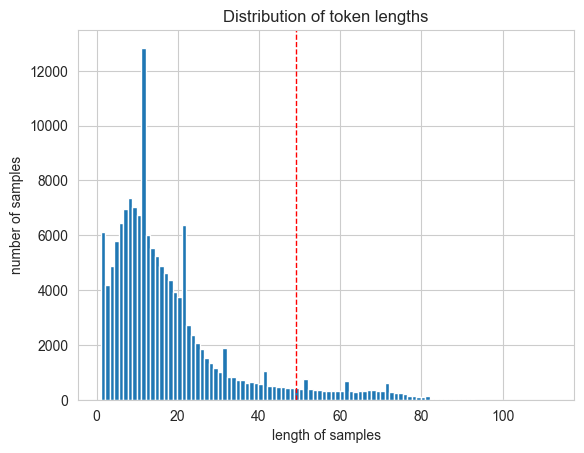

In [76]:
get_token_len(X_train_kiwi, max_tokens=None, hist=False)

In [74]:
max_len = 50
below_threshold_len(max_len, X_train_kiwi)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 93.82400711681414


In [81]:
X_train_kiwi, X_val_kiwi, y_train_kiwi, y_val_kiwi, X_test_kiwi = padding_and_split(X_train_kiwi, X_test_kiwi, y_train_kiwi, max_len)

In [84]:
vocab_size = kiwi_dict['vocab_size']

In [85]:
embedding_dim = 100

In [86]:
def lstm_model(vocab_size, embedding_dim, optimizer='rmsprop'):
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        LSTM(128),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model

In [87]:
model = lstm_model(vocab_size, embedding_dim)

2024-07-25 02:35:38.993693: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-25 02:35:38.994415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2


In [88]:
# 모델 검증
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_lstm_model_kiwi.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [89]:
# 모델 훈련
kiwi_history = model.fit(X_train_kiwi, y_train_kiwi, epochs=20, validation_data=(X_val_kiwi, y_val_kiwi), callbacks=[es, mc])

Epoch 1/20


2024-07-25 02:36:23.052637: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-25 02:36:24.093663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 02:36:24.291786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 02:36:26.055442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3710/3710 [==============================] - ETA: 0s - loss: 0.3808 - acc: 0.8291

2024-07-25 02:38:12.807063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 02:38:12.856925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.84783, saving model to best_lstm_model_kiwi.h5
3710/3710 [==============================] - 118s 31ms/step - loss: 0.3808 - acc: 0.8291 - val_loss: 0.3535 - val_acc: 0.8478
Epoch 2/20
3710/3710 [==============================] - ETA: 0s - loss: 0.3172 - acc: 0.8651
Epoch 2: val_acc improved from 0.84783 to 0.86390, saving model to best_lstm_model_kiwi.h5
3710/3710 [==============================] - 102s 28ms/step - loss: 0.3172 - acc: 0.8651 - val_loss: 0.3193 - val_acc: 0.8639
Epoch 3/20
3710/3710 [==============================] - ETA: 0s - loss: 0.2909 - acc: 0.8790
Epoch 3: val_acc improved from 0.86390 to 0.86754, saving model to best_lstm_model_kiwi.h5
3710/3710 [==============================] - 103s 28ms/step - loss: 0.2909 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8675
Epoch 4/20
3710/3710 [==============================] - ETA: 0s - loss: 0.2710 - acc: 0.8895
Epoch 4: val_acc improved from 0.86754 to 0.87364, saving model to best_

In [90]:
X_test_kiwi.shape

(49638, 50)

In [121]:
def get_roc_auc(model_path, X_test, y_test):
    loaded_model = load_model(model_path)
    # 테스트 데이터에 대한 예측 수행
    y_pred_prob = loaded_model.predict(X_test)  # 모델이 예측한 확률 값
    # ROC 곡선 계산
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    return {'fpr':fpr,'tpr':tpr,'roc_auc':roc_auc}

In [123]:
kiwi_dict['roc_auc'] = get_roc_auc('model/best_lstm_model_kiwi.h5', X_test_kiwi, y_test)

2024-07-25 03:37:53.179577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 03:37:53.285438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1552/1552 [==============================] - 12s 7ms/step


In [125]:
kiwi_dict['name'] = 'kiwi'

In [124]:
kiwi_dict['roc_auc']

{'fpr': array([0.        , 0.        , 0.        , ..., 0.99874387, 0.99894647,
        1.        ]),
 'tpr': array([0.00000000e+00, 4.00657078e-05, 3.08505950e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'roc_auc': 0.9392158892437399}

In [93]:
loaded_model = load_model('best_lstm_model_kiwi.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_kiwi, np.array(y_test))[1]))

2024-07-25 02:50:54.004800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 02:50:54.113600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1552/1552 [==============================] - 15s 9ms/step - loss: 0.3254 - acc: 0.8648

 테스트 정확도: 0.8648


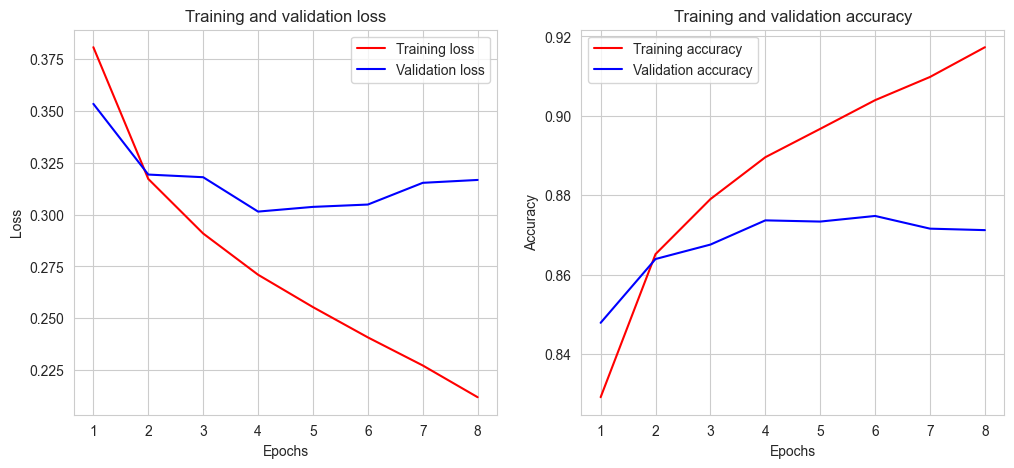

In [94]:
draw_graph(kiwi_history)

In [98]:
y_train = train.label.tolist()

In [100]:
len(y_train)

148909

In [101]:
(X_train, X_test) = bareun_dict['dataset']
X_train, y_train = drop_empty_list(X_train, y_train)
get_token_len(X_train, max_tokens=None, hist=False)

빈 샘플 수 : 507
빈 샘플 제거 후 남은 X train data : 148402
빈 샘플 제거 후 남은 y train data : 148402
토큰 길이 평균: 17.29521165482945
토큰 길이 최소: 1
토큰 길이 최대: 104
토큰 길이 표준편차: 14.855319188649835
설정 최대 길이: 47
전체 문장의 93.6%가 설정값인 47에 포함됩니다.


/opt/homebrew/Caskroom/miniforge/base/envs/DL-tf/lib/python3.8/site-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [102]:
max_len = 50
below_threshold_len(max_len, X_train_kiwi)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 100.0


In [103]:
X_train, X_val, y_train, y_val, X_test = padding_and_split(X_train, X_test, y_train, max_len)
vocab_size = bareun_dict['vocab_size']
model = lstm_model(vocab_size, embedding_dim)
# 모델 검증
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_lstm_model_bareun.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 모델 훈련
bareun_history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20


2024-07-25 02:54:00.843768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 02:54:00.999127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 02:54:01.376463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3711/3711 [==============================] - ETA: 0s - loss: 0.3821 - acc: 0.8283

2024-07-25 02:55:53.073825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 02:55:53.130914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.85199, saving model to best_lstm_model_bareun.h5
3711/3711 [==============================] - 121s 32ms/step - loss: 0.3821 - acc: 0.8283 - val_loss: 0.3423 - val_acc: 0.8520
Epoch 2/20
3711/3711 [==============================] - ETA: 0s - loss: 0.3184 - acc: 0.8643
Epoch 2: val_acc improved from 0.85199 to 0.86298, saving model to best_lstm_model_bareun.h5
3711/3711 [==============================] - 101s 27ms/step - loss: 0.3184 - acc: 0.8643 - val_loss: 0.3184 - val_acc: 0.8630
Epoch 3/20
3711/3711 [==============================] - ETA: 0s - loss: 0.2902 - acc: 0.8795
Epoch 3: val_acc improved from 0.86298 to 0.86567, saving model to best_lstm_model_bareun.h5
3711/3711 [==============================] - 102s 28ms/step - loss: 0.2902 - acc: 0.8795 - val_loss: 0.3113 - val_acc: 0.8657
Epoch 4/20
3711/3711 [==============================] - ETA: 0s - loss: 0.2702 - acc: 0.8908
Epoch 4: val_acc improved from 0.86567 to 0.86958, saving model to

In [104]:
X_test_kiwi.shape

(49638, 50)

In [126]:
bareun_dict['roc_auc'] = get_roc_auc('model/best_lstm_model_bareun.h5', X_test, y_test)

2024-07-25 03:43:07.880675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 03:43:08.070672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1552/1552 [==============================] - 13s 8ms/step


In [127]:
bareun_dict['name'] = 'bareun'

In [106]:
loaded_model = load_model('best_lstm_model_bareun.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, np.array(y_test))[1]))

2024-07-25 03:15:15.594951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 03:15:15.722377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1552/1552 [==============================] - 17s 11ms/step - loss: 0.3463 - acc: 0.8616

 테스트 정확도: 0.8616


## Soynlp

In [ ]:
[kiwi_dict, bareun_dict, ltokenizer_dict, max_score_dict]

In [148]:
y_train = train.label.tolist()
(X_train, X_test) = ltokenizer_dict['dataset']
X_train, y_train = drop_empty_list(X_train, y_train)
get_token_len(X_train, max_tokens=None, hist=False)

In [150]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 100.0


In [151]:
X_train, X_val, y_train, y_val, X_test = padding_and_split(X_train, X_test, y_train, max_len)
vocab_size = ltokenizer_dict['vocab_size']
model = lstm_model(vocab_size, embedding_dim)
# 모델 검증
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_lstm_model_ltokenizer.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 모델 훈련
ltokenizer_history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20


2024-07-25 03:55:10.177978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 03:55:10.401636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 03:55:11.010863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3629/3629 [==============================] - ETA: 0s - loss: 0.4061 - acc: 0.8141

2024-07-25 03:57:09.008708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 03:57:09.090725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.83143, saving model to best_lstm_model_ltokenizer.h5
3629/3629 [==============================] - 128s 34ms/step - loss: 0.4061 - acc: 0.8141 - val_loss: 0.3708 - val_acc: 0.8314
Epoch 2/20
3629/3629 [==============================] - ETA: 0s - loss: 0.3426 - acc: 0.8513
Epoch 2: val_acc improved from 0.83143 to 0.84583, saving model to best_lstm_model_ltokenizer.h5
3629/3629 [==============================] - 107s 30ms/step - loss: 0.3426 - acc: 0.8513 - val_loss: 0.3590 - val_acc: 0.8458
Epoch 3/20
3629/3629 [==============================] - ETA: 0s - loss: 0.3117 - acc: 0.8682
Epoch 3: val_acc improved from 0.84583 to 0.84858, saving model to best_lstm_model_ltokenizer.h5
3629/3629 [==============================] - 112s 31ms/step - loss: 0.3117 - acc: 0.8682 - val_loss: 0.3501 - val_acc: 0.8486
Epoch 4/20
3629/3629 [==============================] - ETA: 0s - loss: 0.2944 - acc: 0.8772
Epoch 4: val_acc did not improve from 0.84858
3629/362

In [152]:
X_test.shape

(49638, 50)

In [153]:
ltokenizer_dict['roc_auc'] = get_roc_auc('model/best_lstm_model_ltokenizer.h5', X_test, y_test)

2024-07-25 04:11:46.332966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 04:11:46.383797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1552/1552 [==============================] - 999s 644ms/step


In [154]:
ltokenizer_dict['name'] = 'ltokenizer'

In [155]:
loaded_model = load_model('best_lstm_model_ltokenizer.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, np.array(y_test))[1]))

2024-07-25 04:28:25.979548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 04:28:26.064117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1552/1552 [==============================] - 18s 11ms/step - loss: 0.3661 - acc: 0.8357

 테스트 정확도: 0.8357


In [156]:
y_train = train.label.tolist()
(X_train, X_test) = max_score_dict['dataset']
X_train, y_train = drop_empty_list(X_train, y_train)
get_token_len(X_train, max_tokens=None, hist=False)

빈 샘플 수 : 1254
빈 샘플 제거 후 남은 X train data : 147655
빈 샘플 제거 후 남은 y train data : 147655
토큰 길이 평균: 10.641928820561445
토큰 길이 최소: 1
토큰 길이 최대: 66
토큰 길이 표준편차: 8.955222333055238
설정 최대 길이: 28
전체 문장의 93.5%가 설정값인 28에 포함됩니다.


/opt/homebrew/Caskroom/miniforge/base/envs/DL-tf/lib/python3.8/site-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [157]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.93904710304426


In [158]:
X_train, X_val, y_train, y_val, X_test = padding_and_split(X_train, X_test, y_train, max_len)
vocab_size = max_score_dict['vocab_size']
model = lstm_model(vocab_size, embedding_dim)
# 모델 검증
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_lstm_model_max_score.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 모델 훈련
max_score_history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20


2024-07-25 04:28:44.834795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 04:28:45.011564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 04:28:45.666623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3692/3692 [==============================] - ETA: 0s - loss: 0.3874 - acc: 0.8254

2024-07-25 04:30:46.099218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 04:30:46.177062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.84718, saving model to best_lstm_model_max_score.h5
3692/3692 [==============================] - 130s 34ms/step - loss: 0.3874 - acc: 0.8254 - val_loss: 0.3431 - val_acc: 0.8472
Epoch 2/20
3692/3692 [==============================] - ETA: 0s - loss: 0.3225 - acc: 0.8634
Epoch 2: val_acc improved from 0.84718 to 0.85889, saving model to best_lstm_model_max_score.h5
3692/3692 [==============================] - 115s 31ms/step - loss: 0.3225 - acc: 0.8634 - val_loss: 0.3267 - val_acc: 0.8589
Epoch 3/20
3692/3692 [==============================] - ETA: 0s - loss: 0.2926 - acc: 0.8787
Epoch 3: val_acc improved from 0.85889 to 0.86367, saving model to best_lstm_model_max_score.h5
3692/3692 [==============================] - 1993s 540ms/step - loss: 0.2926 - acc: 0.8787 - val_loss: 0.3180 - val_acc: 0.8637
Epoch 4/20
3692/3692 [==============================] - ETA: 0s - loss: 0.2738 - acc: 0.8881
Epoch 4: val_acc did not improve from 0.86367
3692/3692

In [159]:
X_test.shape

(49638, 50)

In [160]:
max_score_dict['roc_auc'] = get_roc_auc('model/best_lstm_model_max_score.h5', X_test, y_test)

2024-07-25 06:28:26.479225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 06:28:26.591164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1552/1552 [==============================] - 17s 8ms/step


In [161]:
max_score_dict['name'] = 'max_score'

In [162]:
loaded_model = load_model('best_lstm_model_max_score.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, np.array(y_test))[1]))

2024-07-25 06:28:47.695292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 06:28:47.864417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1552/1552 [==============================] - 16s 10ms/step - loss: 0.3326 - acc: 0.8570

 테스트 정확도: 0.8570


In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

def get_roc_curve(model_path, X_test, y_test):
    # 모델 불러오기
    loaded_model = load_model(model_path)

    # 테스트 데이터에 대한 예측 수행
    y_pred_prob = loaded_model.predict(X_test)  # 모델이 예측한 확률 값

    # ROC 곡선 계산
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # ROC 곡선 그리기
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print("\n테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
    print("ROC AUC: %.4f" % roc_auc)

In [110]:
y_test = np.array(y_test)

2024-07-25 03:15:49.757904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-07-25 03:15:49.844045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1552/1552 [==============================] - 13s 8ms/step


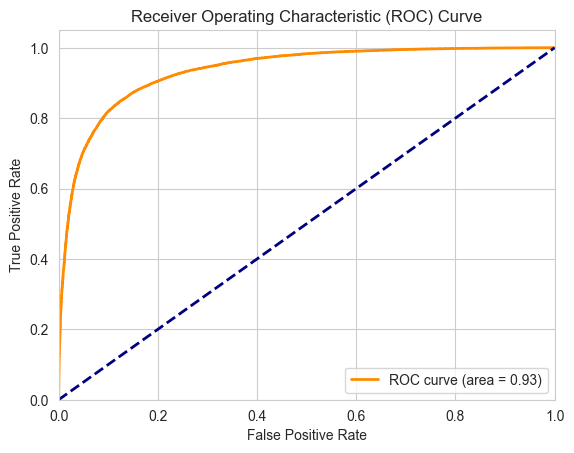

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

In [109]:
path = 'model/best_lstm_model_bareun.h5'
get_roc_curve(path, X_test, y_test)

In [116]:
from glob import glob

model_list = glob('model/*.h5')

In [117]:
model_list

['model/best_lstm_model_okt.h5',
 'model/best_lstm_model_hannanum.h5',
 'model/best_lstm_model_okt_stem.h5',
 'model/best_lstm_model_kiwi.h5',
 'model/best_lstm_model_sentencepiece_bpe.h5',
 'model/best_lstm_model_sentencepiece_10000.h5',
 'model/best_lstm_model_komoran.h5',
 'model/best_lstm_model_bareun.h5',
 'model/best_lstm_model_mecab.h5']

In [ ]:
kiwi_dict['roc_auc']

In [139]:
def get_roc_curve(model_list):
    # 모델 불러오기
    plt.figure()
    for model in model_list:
        roc_auc_dict = model['roc_auc']
        # ROC 곡선 그리기
        name = model['name']
        roc_auc = round(roc_auc_dict['roc_auc'],3)
        plt.plot(roc_auc_dict['fpr'], roc_auc_dict['tpr'], lw=2, label=f'{name} (area = {roc_auc})')
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [163]:
model_list = [kiwi_dict, bareun_dict, ltokenizer_dict, max_score_dict]

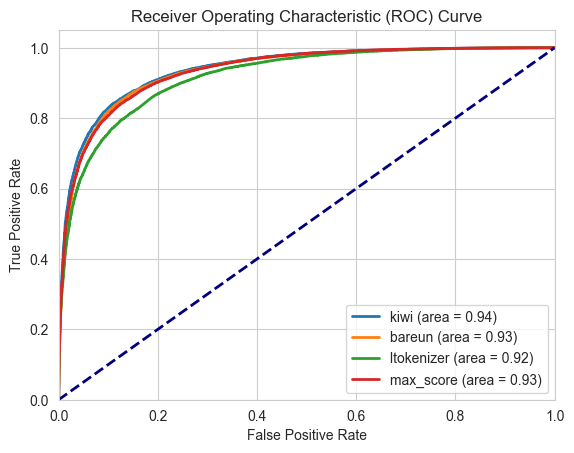

In [164]:
get_roc_curve(model_list)